In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia

In [5]:
# ==============================================
# 📦 Install Required Libraries
# ==============================================
import pandas as pd
import torch
import transformers
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

from tqdm import tqdm



2025-04-21 17:28:05.398296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745256485.639968      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745256485.711542      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# ==============================================
# 🔠 Load Tokenizer and Preprocess Data
# ==============================================
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def domain_shift_filter(example):
    words = example["text"].lower().split()
    word_count = len(words)
    unique_ratio = len(set(words)) / max(len(words), 1)

    # Keep samples with longer structure and richer vocab (to match test set)
    return 25 <= word_count <= 90 and unique_ratio >= 0.7

# Apply filter
filtered_dataset = dataset.filter(domain_shift_filter)

print(f"Filtered dataset size: {len(filtered_dataset)} / {len(dataset)} ({(len(filtered_dataset)/len(dataset))*100:.2f}%)")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filtered dataset size: 110716 / 120000 (92.26%)


In [7]:
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)
    return tokenized

tokenized_dataset = filtered_dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map:   0%|          | 0/110716 [00:00<?, ? examples/s]

In [8]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [9]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
#model = get_peft_model(model, peft_config)

In [11]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [12]:
# ==============================================
# 🧠 Load Pretrained Model and Inject LoRA
# ==============================================




# PEFT Config
peft_config = LoraConfig(
    # r=10,
    # lora_alpha=32,
    # lora_dropout=0.3,
    # bias='none',
    # target_modules=['query','fc1','fc2','value','out_proj'],  
    # task_type="SEQ_CLS",
    r=6,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    target_modules=['query', 'value'],  # Only attention layers
    task_type="SEQ_CLS",
)

In [13]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [14]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


In [15]:
'''for name, module in peft_model.named_modules():
    if "classifier" in name:
        print(name, type(module))
'''

'for name, module in peft_model.named_modules():\n    if "classifier" in name:\n        print(name, type(module))\n'

In [16]:
# ==============================================
# 📊 Evaluation Metric
# ==============================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [18]:
# ==============================================
# ⚙️ Define Training Arguments
# ==============================================

# Setup Training args
output_dir = "/kaggle/working/results"
training_args = TrainingArguments(
    output_dir=output_dir,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    # #eval_steps=250,
    # #save_steps=250,
    # load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    # greater_is_better=True,
    # learning_rate=2e-4,
    # weight_decay=0.01,
    # lr_scheduler_type="cosine",
    # warmup_ratio=0.1,
    # label_smoothing_factor=0.1,
    # num_train_epochs=8,
    # per_device_train_batch_size=32,
    # per_device_eval_batch_size=64,
    # save_total_limit=3,
    # logging_steps=50,
    per_device_train_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
from transformers import TrainingArguments
print("TrainingArguments class path:", TrainingArguments.__module__)

TrainingArguments class path: transformers.training_args


In [20]:
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)


In [21]:
# ==============================================
# 🧰 Trainer Helper Function
# ==============================================
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          #callbacks=[early_stopping],
      )


In [22]:
import torch
print(torch.cuda.is_available())

True


In [23]:
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          #callbacks=[early_stopping],
      )

In [24]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.222900,0.249668,0.917188
2,0.192100,0.221636,0.935937
3,0.180600,0.209045,0.934375
4,0.169600,0.206516,0.940625
5,0.168800,0.206530,0.942187


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [25]:
!pip install evaluate

In [26]:
import evaluate
# ==============================================
# 🧪 Evaluation Function (Supports Labelled/Unlabelled)
# ==============================================
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [44]:
# ==============================================
# 🚀 Train and Evaluate
# ==============================================

eval_metrics, predsEval = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)


100%|██████████| 80/80 [00:09<00:00,  8.89it/s]

Evaluation Metric: {'accuracy': 0.9421875}


In [37]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [76]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv("/kaggle/working/inference_output.csv", index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]

Inference complete. Predictions saved to inference_output.csv


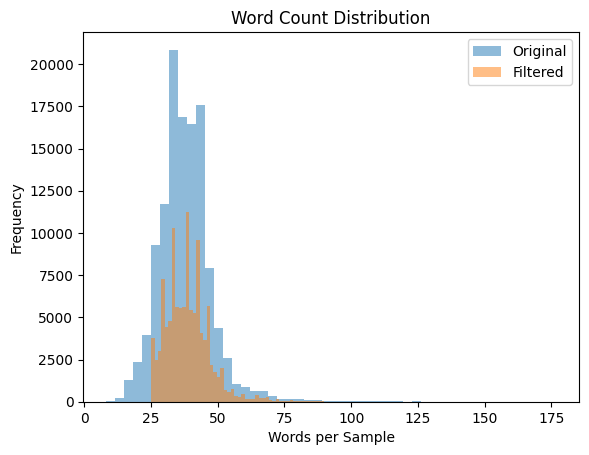

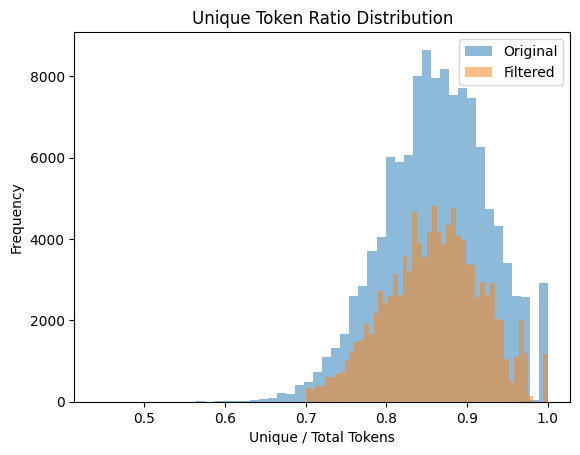

In [47]:
# ───────────────────────────────────────────────────────────
# 📊 Preprocessing Distributions — Word Count & Unique Ratio
# ───────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import pandas as pd

# 1) Original dataset stats
df_orig = pd.DataFrame(dataset["text"], columns=["text"])
df_orig["word_count"] = df_orig["text"].apply(lambda t: len(t.split()))
df_orig["unique_ratio"] = df_orig["text"].apply(
    lambda t: len(set(t.lower().split())) / max(len(t.split()), 1)
)

# 2) Filtered dataset stats
df_filt = pd.DataFrame(filtered_dataset["text"], columns=["text"])
df_filt["word_count"] = df_filt["text"].apply(lambda t: len(t.split()))
df_filt["unique_ratio"] = df_filt["text"].apply(
    lambda t: len(set(t.lower().split())) / max(len(t.split()), 1)
)

# Plot: Word Count
plt.hist(df_orig["word_count"], bins=50, alpha=0.5, label="Original")
plt.hist(df_filt["word_count"], bins=50, alpha=0.5, label="Filtered")
plt.title("Word Count Distribution")
plt.xlabel("Words per Sample")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot: Unique Token Ratio
plt.hist(df_orig["unique_ratio"], bins=50, alpha=0.5, label="Original")
plt.hist(df_filt["unique_ratio"], bins=50, alpha=0.5, label="Filtered")
plt.title("Unique Token Ratio Distribution")
plt.xlabel("Unique / Total Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()
# ───────────────────────────────────────────────────────────


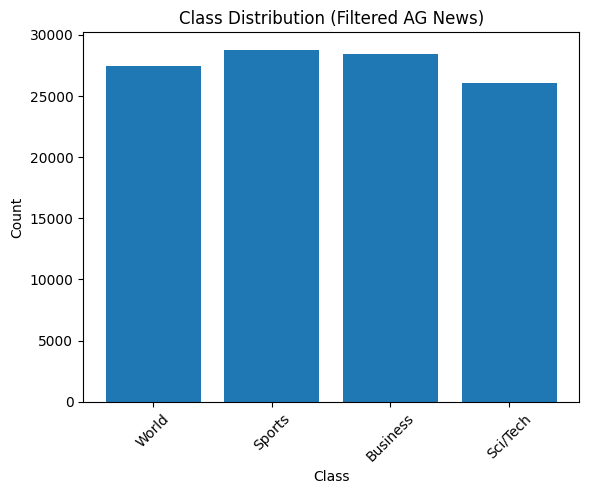

In [41]:
# ───────────────────────────────────────────────────────────
# 🏷️ Class distribution
import matplotlib.pyplot as plt
import pandas as pd

# pull the labels column
labels = pd.Series(filtered_dataset['label'])
counts = labels.value_counts().sort_index()

plt.bar(
    [class_names[i] for i in counts.index],
    counts.values
)
plt.title('Class Distribution (Filtered AG News)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
# ───────────────────────────────────────────────────────────


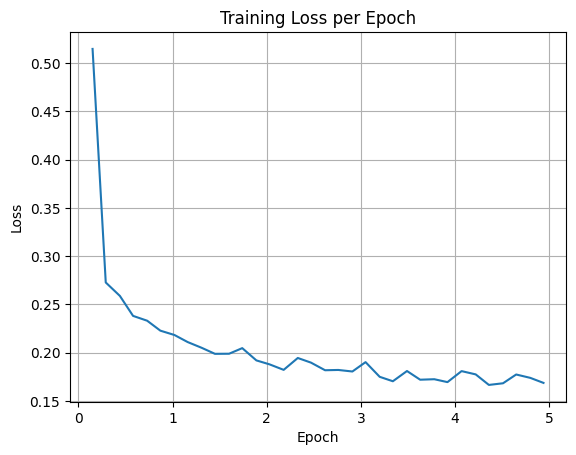

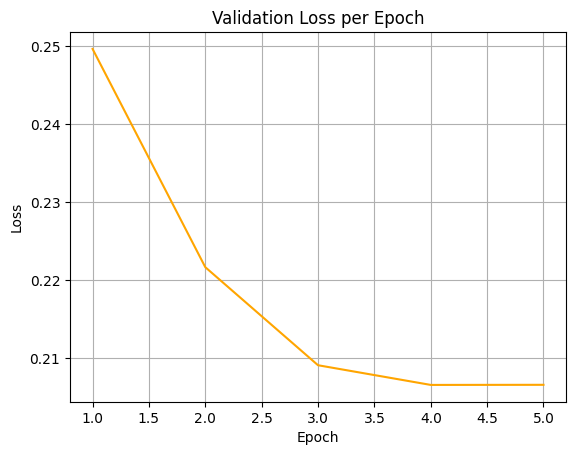

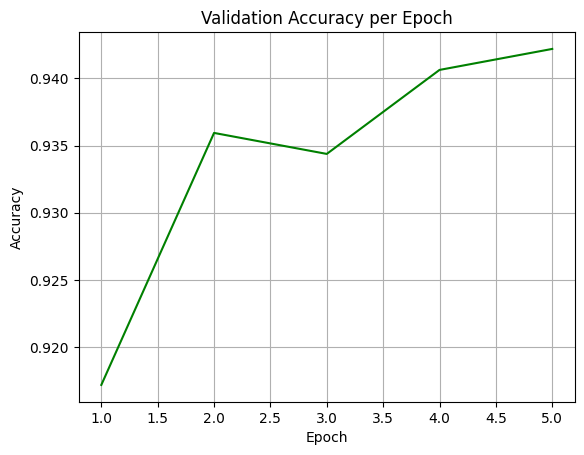

In [75]:
# ───────────────────────────────────────────────────────────
# 📈 Training Loss, Validation Loss, and Accuracy per Epoch
# ───────────────────────────────────────────────────────────

from collections import defaultdict
import matplotlib.pyplot as plt

logs = peft_lora_finetuning_trainer.state.log_history

def rounded(epoch_val):
    return round(epoch_val, 2)

# -------------------------------
# 1. Clean training loss per epoch
# -------------------------------
train_loss_map = defaultdict(list)
for entry in logs:
    if "loss" in entry and "epoch" in entry:
        ep = rounded(entry["epoch"])
        train_loss_map[ep].append(entry["loss"])

# Keep only the last logged loss per epoch
train_epochs = sorted(train_loss_map.keys())
train_loss = [train_loss_map[ep][-1] for ep in train_epochs]

# 2) Validation loss and accuracy
val_epochs = [entry["epoch"] for entry in logs if "eval_loss" in entry]
val_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
val_acc = [entry["eval_accuracy"] for entry in logs if "eval_accuracy" in entry]

# --- Plot: Training Loss ---
plt.plot(train_epochs, train_loss, label='Train Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Plot: Validation Loss ---
plt.plot(val_epochs, val_loss,  color='orange', label='Val Loss')
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Plot: Validation Accuracy ---
plt.plot(val_epochs, val_acc, color='green', label='Val Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()




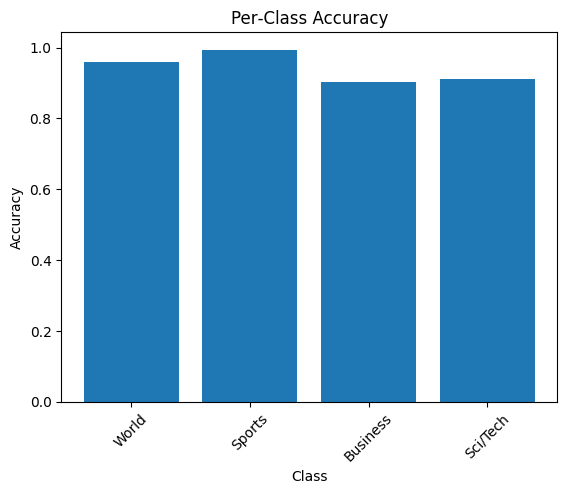


Classification Report:

              precision    recall  f1-score   support

       World       0.95      0.96      0.96       145
      Sports       0.98      0.99      0.99       168
    Business       0.90      0.90      0.90       167
    Sci/Tech       0.93      0.91      0.92       160

    accuracy                           0.94       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.94      0.94      0.94       640



In [69]:
# ───────────────────────────────────────────────────────────
# 📊 Confusion Matrix & Per‑Class Accuracy
# ───────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) Per‑class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.bar(class_names, per_class_acc)
plt.title("Per‑Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# 2) Full text report
print("\nClassification Report:\n")
print(classification_report(true_labels, preds, target_names=class_names))
# ───────────────────────────────────────────────────────────


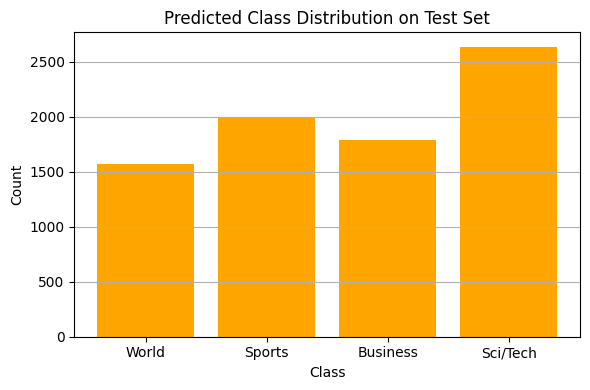

| Class    |   Count |
|:---------|--------:|
| World    |    1568 |
| Sports   |    2002 |
| Business |    1793 |
| Sci/Tech |    2637 |


In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# If preds is a NumPy array, you can use it directly
if not isinstance(preds, np.ndarray):
    preds = preds.numpy()

# Optional: if you have class_names list (from AG News)
# Example: class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Count class frequencies
class_counts = pd.Series(preds).value_counts().sort_index()

# If you have class names, map them
if 'class_names' in globals():
    class_labels = [class_names[i] for i in class_counts.index]
else:
    class_labels = class_counts.index.astype(str)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_labels, class_counts.values, color='orange')
plt.title("Predicted Class Distribution on Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Optional: print as a table
df_dist = pd.DataFrame({
    "Class": class_labels,
    "Count": class_counts.values
})
print(df_dist.to_markdown(index=False))
